__Forecasting Technology Trends by Patent Database__
---
Somaye Farhadi, PhD<br>
The Data Incubator Fellowship Program<br>
Fall 2019


__Buisiness objective:__<br>

How do breakthrough technologies emerge? What is the life-time of a specific technology? And can we predict anything about the technology landscape in future?<br>
Here, I propose to utilize patent issuance database to get useful information about technology trends and ultimately make predictions for the fate of a specific technology. I am using patent data because patents represent innovation, and any trend in patent issuance and citation gives us significant information about technology landscape.<br>
The ultimate outcome of this data analysis could be applied to various sectors. Just to name a few are the funding agencies, Venture capital firms, and concerns regarding technology transfer. 
    

__Data Source and Streaming:__<br>
The data I have used are publicly available and sourced from US patent office database. In particular, I downloaded two databases from https://www.patentsview.org/download/. Namely "uspatentcitation.tsv" and "cpc_current.tsv". Both these spreadsheets contained millions of rows and required specific handling. I ultimately queried three types of information: The occurrence of a patent citation, The category of that cited patent, and the year it was cited (More detailed are provided in Pre-Processing-Data notebook).
There are different schemes to categorize patents, but uspto uses a scheme called CPC to assign letters and numbers which could be tracked to specific classifications as sections subsections groups and subgroups. For my analysis, I looked at the groups of patents and ignored their subgroups because it introduces a lot of noise.


__Graph-based Analysis:__<br>
The analysis procedure I chose for forcasting technology trends was a combination of network analysis and linear regression.<br>
The idea is to construct a graph based on citations, where each node represent a patent group (e.g. group H01L, which is Semiconductor Devices). The links of this graph represent a patent citation from group A to group B. With this analogy, we end up with a weighted directional graph, which would evolve over time based on new patent citation incidences. I then perform a _PageRank_ analysis on this graph and apply a score to each node. <br>
The next step is to predict the PageRank scores based on the current structure of the graph and its past history. For this purpose, I assumed a simple Markov chain model, and performed a linear regression. The features of this model consisted of two variables: 1- The current PageRanke value of a node, P(t), and 2- The gradient of the PageRanke value (i.e. [P(t-1)-P(t)]/P(t)). The target variable was the future PageRanke value, P(t+1).<br>
I constructed a model based on linear regression with cross-validation.<br>
Finally, after being confident about the performance of the model, I applied the model to current PageRank values to predict the upcoming PageRanks.<br>

It is important to note that I take PageRank values as a measure on how _active_ a particular node is, which subsequently signals the trendiness of that particular group in technology landscape.


__A quick note:__ In this notebook, I have focused on the section "H" in CPC scheme, but the procedure could be applied to any section.

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import pickle
import os

from collections import Counter
from itertools import permutations 

In [3]:
# Local saved files
data_drct = '/home/somayeh/Documents/Career/Data_Incubator/Capstone/Data/'
result_drct = '/home/somayeh/Documents/Career/Data_Incubator/Capstone/Result/'

filename2 = 'cpc_current.tsv'  # information on citation groups
filename3 = 'uspatentcitation.tsv'  # information on patent and its citations and the year it was issued

__1. Cleaning up the data and preparing for graph analysis__
--

This function gets ONLy patents which are in section H. Note that he data is partally loaded, cleaned and stored in a dataframe:

In [3]:
def get_section(section ="H"):
    df_chunk = pd.read_csv(data_drct+filename2,sep='\t',header=0, chunksize=1000000)
    patent_list2 = []  
    for cnt, chunk in enumerate(df_chunk):
        chunk = chunk[chunk["section_id"] == "H"]
        chunk = chunk[["patent_id","group_id"]]
        chunk["patent_id"] = chunk["patent_id"].astype(int)
        chunk = chunk.drop_duplicates()
        patent_list2.append(chunk)

    patent_id_group = pd.concat(patent_list2)
    del patent_list2
    return(patent_id_group)

In [4]:
patent_id_group = get_section()

As seen, patent_id_group dataframe has two columns: patent_id and its group_id:

In [5]:
patent_id_group.head()

,patent_id,group_id
0,4205226,H01J
2,4205227,H01L
13,4205232,H05F
14,4205232,H01H
15,4205232,H01J


In [6]:
patent_id_group.to_pickle(result_drct+"/patent_id_group_H.pkl")

In [7]:
del(patent_id_group)

The following function combines all required infomation for each year and stores it (per year) locally:

In [3]:
def get_df_per_year(yr):
    print(yr)
    fname = result_drct+'/patent_citation_yr/'+str(yr)+'.pkl'
    with open(fname, 'rb') as f:
        df = pickle.load(f)
    df = (df
            .drop(['patent_id','citation_id', 'year'], axis=1)
            .join(df[['patent_id','citation_id', 'year']].apply(pd.to_numeric, errors='coerce')))
    df = df.dropna()
    df[['patent_id','citation_id']] = df[['patent_id','citation_id']].astype(int)
    df = df.reset_index(drop=True)
    
    fname = result_drct+"/patent_id_group_H.pkl"
    with open(fname, 'rb') as f:
        patent_id_group = pickle.load(f)
    patent_id_group = patent_id_group[["patent_id", "group_id"]]
    patent_id_group = patent_id_group.loc[patent_id_group["patent_id"].isin(df.patent_id)]

    df = pd.merge(df, patent_id_group, how='left', on=['patent_id'])

    df = df.rename(columns={'year': 'year_citation', 'group_id':'patent_group','patent_id': 'p_id', 'citation_id':'patent_id'})
    df = pd.merge(df, patent_id_group, how='left', on=['patent_id'])
    df = df.rename(columns={'p_id': 'patent_id', 'patent_id':'citation_id', 'group_id':'citation_group'})
    df = df.dropna()
    df = df.reset_index(drop=True)
    del patent_id_group 

    fname = result_drct+"/patent_id_year.pkl"
    with open(fname, 'rb') as f:
        df2 = pickle.load(f)
#     df2 = df2.loc[df2["year"]>=yr-5]
    df2 = df2.rename(columns={'year': 'year_patent', 'citation_id':'patent_id'})
    df = pd.merge(df, df2, how='left', on=['patent_id'])
    df = df.dropna()
    df["year_patent"] = df["year_patent"].astype(int)
    
    drc = result_drct+'/citations_year/'
    if not os.path.exists(drc):
        os.makedirs(drc)
    fname = drc+str(yr)+'.pkl'
    with open(fname, 'wb') as f:
        pickle.dump(df, f)


In [4]:
for yr in range(1960,2020):
    get_df_per_year(yr)

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


The following function orders the files based on citation year:

In [11]:
def get_df_per_year2(yr):
    print(yr)
    DF = pd.DataFrame()
    for yr2 in range(1960,2020):
        fname = result_drct+'/citations_year/'+str(yr2)+'.pkl'
        with open(fname, 'rb') as f:
            df = pickle.load(f)
        df = df[df.year_patent==yr]
        DF = pd.concat([DF,df],sort=False)
    drc = result_drct+'/citations_year2/'
    if not os.path.exists(drc):
        os.makedirs(drc)
    fname = drc+str(yr)+'.pkl'
    with open(fname, 'wb') as f:
        pickle.dump(DF, f)

In [12]:
for yr in range(1960,2020):
    get_df_per_year2(yr)

1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


__2. Constructing the weighted citation graph__
--

Now, we are prepared to construct the citation graph. Note that this graph is constructed individually for all citation in a specific year, and the nodes represent the patent group IDs. The weight of the link between node A and B is proportional to the number of citations groing from A to B. We represent teh graph by its adjacancy matrix:

In [224]:
#List of all unique groups in H section
# get list of group ids stored in patent_id_group data file   
def get_adjacancy_matrix():
    fname = result_drct+"/patent_id_group_H.pkl"
    with open(fname, 'rb') as f:
        df2 = pickle.load(f)
    group_list = df2.group_id.unique()
    group_list.sort()
    del df2

    adjacancy_matrix =  list(zip(group_list,group_list))+ list(permutations(group_list, 2))
#     adjacancy_matrix =  list(permutations(group_list, 2))
    group_list = {group_list[i]:i for i in range(len(group_list))}
    return(group_list, adjacancy_matrix)

def get_adjecanct_matrix_year(year):
    
    group_list, adjacancy_matrix = get_adjacancy_matrix()
    DF= pd.DataFrame()
#     for yr in range(1960,year+1):
#         fname = result_drct+'/citations_year2/'+str(yr)+'.pkl'
#         with open(fname, 'rb') as f:
#             df = pickle.load(f)
#         df = df.drop_duplicates()
#         DF = pd.concat([DF,df],sort=False)
#         del df
    fname = result_drct+'/citations_year2/'+str(year)+'.pkl'
    with open(fname, 'rb') as f:
        df = pickle.load(f)
    df = df.drop_duplicates()
    DF = pd.concat([DF,df],sort=False)
    del df

    all_links = list(zip(DF.patent_group, DF.citation_group))
    unique_links = set(list(zip(DF.patent_group, DF.citation_group)))
    del DF

    dd = Counter(all_links)
    for item in adjacancy_matrix:
        if item in dd.keys():
            pass 
        else:
            dd[item] = 0

#     dd = { item: dd[item] for item in dd.keys() if item in adjacancy_matrix }
    
    A_M = np.zeros((len(group_list),len(group_list)))
    for k,v in dd.items():
        x, y = list(k)[0],list(k)[1]
        idx, idy = group_list[x], group_list[y]
        A_M[idx][idy] = v
    return(dd,A_M)

__As an example__, I have visualized the adjacancy matrix for year 2010:

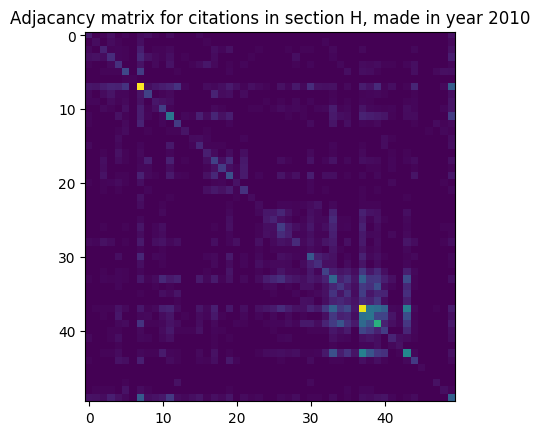

In [327]:
dd,A_M = get_adjecanct_matrix_year(2010)
plt.imshow(np.sqrt(A_M))
plt.title("Adjacancy matrix for citations in section H, made in year 2010")
plt.show()

__Creating Graph from the adjacency matrix using Networkx:__

In [292]:
G2 = nx.from_numpy_matrix(A_M, create_using=nx.MultiDiGraph)
pr = nx.pagerank_numpy(G2, alpha=0.8)

print(nx.info(G2))

Name: 
Type: MultiDiGraph
Number of nodes: 50
Number of edges: 961
Average in degree:  19.2200
Average out degree:  19.2200


__3. PageRank Analysis of Graph__
---

Now we can iteratively create the _PageRank_ features for each year, as the citation graph evolves over time:

In [293]:
def create_feature_df(year):
    P_R = pd.DataFrame()
    for year in range(year,2020):
        _,A_M = get_adjecanct_matrix_year(year)
        G2 = nx.from_numpy_matrix(A_M, create_using=nx.MultiDiGraph)
        pr = nx.pagerank_numpy(G2, alpha=0.9)
        P_R["pr_"+str(year)] = list(pr.values())

    P_R2 = pd.DataFrame()
    columns = list(P_R.columns)
    for i in range(len(columns)-1):
        P_R2["pr_"+columns[i][3:]] = (P_R[columns[i+1]]-P_R[columns[i]])/P_R[columns[i]]

    P_R3 = pd.DataFrame()
    columns = list(P_R.columns)
    for i in range(len(columns)-1):
        P_R3["pr_"+columns[i][3:]]= P_R[columns[i+1]]

    P_R_combined = pd.DataFrame(P_R.stack())
    P_R2_combined = pd.DataFrame(P_R2.stack())
    P_R3_combined = pd.DataFrame(P_R3.stack())
    df = pd.concat([P_R_combined,P_R2_combined,P_R3_combined], axis = 1)
    symbols = ['Pagerank', 'velocity', 'predicted_PageRange']

    df.columns = symbols
    return(df)

In [294]:
df = create_feature_df(1980)

The create_feature_df function outputs a dataframe which has three columns: 1- The current PageRank score of a node, the gradient/velocity of PageRank for that node, and the PageRank of that node for the upcoming time point (meaning the next year):

In [295]:
df.head()

Pagerank  velocity  predicted_PageRange
0 pr_1980  0.003694  4.244051             0.019374
  pr_1981  0.019374  0.703186             0.032997
  pr_1982  0.032997 -0.728084             0.008973
  pr_1983  0.008973  0.519185             0.013631
  pr_1984  0.013631  1.778496             0.037874

In [277]:
df = df.dropna()

__4. Creating Regression Model for PageRank Prediction__
---

Now we are ready to do a regression model fitting to our data. First, I do a quick exploration to see model performance:

In [279]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge


In [280]:
# comparing 3 models
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge(),}

In [281]:
def test(models, data, iterations = 100):
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(data[["Pagerank","velocity"]].values, 
                                                                df['predicted_PageRange'].values, 
                                                                test_size= 0.2)
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return (pd.DataFrame(results))

Testing these 3 models (LinearRegression, Lasso, and Ridge) shows that the performance of a simple linear regression is highest:

In [282]:
test(models, df)

,OLS,Lasso,Ridge
0,0.843541,0.000000,0.657484
1,0.834298,-0.003502,0.655757


__Now building the model with cross validation:__

In [283]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pipe_all = Pipeline([
                     ('standard', StandardScaler()),
                     ('regressor', LinearRegression())])

X=df[["Pagerank","velocity"]].values
y=df['predicted_PageRange'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe_all.fit(X_train,y_train)
pipe_all.score(X_test, y_test)

0.8906065669898546

__5. And finally, predicting trends for year 2018__
--

Having model with R2 score = 0.9 we can now predict the PageRank scores for the upcoming year. (Note that I only had data till 2017, and prediction goes to 2018 where we still do not have data output)

In [305]:
_,A_M = get_adjecanct_matrix_year(2017)
G2 = nx.from_numpy_matrix(A_M, create_using=nx.MultiDiGraph)
pr = nx.pagerank_numpy(G2, alpha=0.9)

_,A_M = get_adjecanct_matrix_year(2016)
G2 = nx.from_numpy_matrix(A_M, create_using=nx.MultiDiGraph)
pr2 = nx.pagerank_numpy(G2, alpha=0.9)

X = [[pr[i],pr2[i]] for i in range(len(pr))]

In [308]:
pred = pipe_all.predict(X)

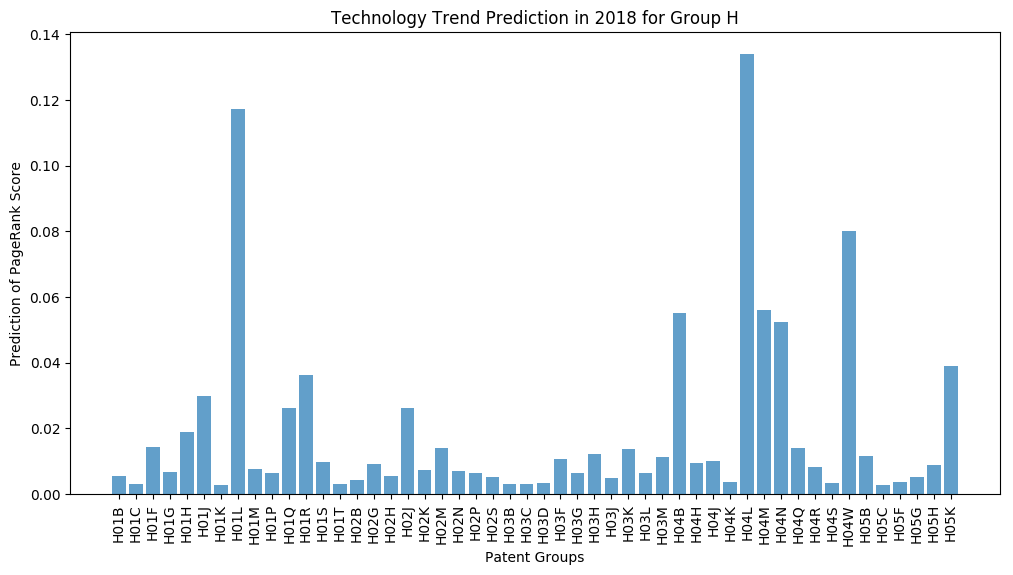

In [328]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(12, 6))

objects,_ =  get_adjacancy_matrix()
y_pos = np.arange(len(objects))
performance = pred

plt.bar(y_pos, performance, align='center', alpha=0.7)
plt.xticks(y_pos, objects, rotation='vertical')

plt.xlabel('Patent Groups')
plt.ylabel('Prediction of PageRank Score')
plt.title('Technology Trend Prediction in 2018 for Group H')


plt.show()

__6. Final note on Prediction__
---

Top 3 groups:<br>
    
    H04L: TRANSMISSION OF DIGITAL INFORMATION
    H01L: SEMICONDUCTOR DEVICES
    H04W: WIRELESS COMMUNICATION NETWORKS<br>
    
My analysis shows that the top 3 groups mentioned above are going to have the highest PageRank value in the citation graph of section "H" for th eupcoming year. This plainly signals these three groups have higher importance in the graph and could be regarded as the trend drivers for the technology landscape in the next year.